# A/B-тестирование

## Описание проекта

В распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов. Необходимо оцените корректность проведения теста и проанализируйте его результаты.

Цели исследования: провести оценку результатов A/B-теста.

Задачи проекта:

1. Подготовка и предобработка данных.
2. Проверка данных на соответствие техническому заданию.
3. Исследовательский анализ данных.
4. Анализ результатов А/В-тестирования.
5. Интерпретация результатов и подготовка выводов.

### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

## Загрузка данных и подготовка к анализу

In [160]:
# Python модули
import pandas as pd
import datetime as dt
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import requests 
from urllib.parse import urlencode 
from plotly import graph_objects as go
from pandas.plotting import register_matplotlib_converters
from plotly.subplots import make_subplots
# Конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()
pd.options.mode.chained_assignment = None
# Изменение кол-ва символов в ячейке
pd.options.display.max_colwidth = 120

In [161]:
# Загрузка данных в датасеты
# Используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = dict(ab_project_marketing_events='https://disk.yandex.ru/d/ZVC7GUYYckKnGQ',
                  final_ab_events='https://disk.yandex.ru/d/pgKgZ9lRp0Enwg',
                  final_ab_new_users='https://disk.yandex.ru/d/Qrto8Gerpu424g',
                  final_ab_participants='https://disk.yandex.ru/d/nhGUR3ZkNIG4VA')
for key, purl in public_key.items():
    # Получаем url 
    final_url = base_url + urlencode(dict(public_key=purl)) 
    response = requests.get(final_url) 
    download_url = response.json()['href']     
    # Загружаем файл в df 
    try: 
        download_response = requests.get(download_url)
        globals()[key] = pd.read_csv(download_url, sep=',')
        print(f'Загружены данные в датасет: {key} {purl}')
    except:
        print('Error in upload data')

Загружены данные в датасет: ab_project_marketing_events https://disk.yandex.ru/d/ZVC7GUYYckKnGQ
Загружены данные в датасет: final_ab_events https://disk.yandex.ru/d/pgKgZ9lRp0Enwg
Загружены данные в датасет: final_ab_new_users https://disk.yandex.ru/d/Qrto8Gerpu424g
Загружены данные в датасет: final_ab_participants https://disk.yandex.ru/d/nhGUR3ZkNIG4VA


In [162]:
# Данные в датасетах
for str in public_key.keys():
    print('Dataset:',str)
    display(locals()[str].head())
    display(locals()[str].info())
    print('_____________________________________________')

Dataset: ab_project_marketing_events


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

_____________________________________________
Dataset: final_ab_events


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

_____________________________________________
Dataset: final_ab_new_users


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

_____________________________________________
Dataset: final_ab_participants


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

_____________________________________________


### Описание данных

`ab_project_marketing_events` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users` — пользователи, зарегистрировавшиеся с 7 до 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

### Предобработка данных

In [163]:
# Приведем данные в столбцах к формату datetime
ab_project_marketing_events.start_dt = pd.to_datetime(ab_project_marketing_events.start_dt)
ab_project_marketing_events.finish_dt = pd.to_datetime(ab_project_marketing_events.finish_dt)
final_ab_new_users.first_date = pd.to_datetime(final_ab_new_users.first_date)
final_ab_events.event_dt = pd.to_datetime(final_ab_events.event_dt)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Даты преобразованы - порядок!

In [164]:
# Подсчёт пропусков
for str in public_key.keys():
    print('Dataset:',str)
    display(locals()[str].isna().sum())
    print('_____________________________________________')


Dataset: ab_project_marketing_events


name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

_____________________________________________
Dataset: final_ab_events


user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

_____________________________________________
Dataset: final_ab_new_users


user_id       0
first_date    0
region        0
device        0
dtype: int64

_____________________________________________
Dataset: final_ab_participants


user_id    0
group      0
ab_test    0
dtype: int64

_____________________________________________


In [165]:
# Посмотрим, на каие события приходится больше всего пропусков
events_na = final_ab_events['event_name'].value_counts().reset_index()
events_na['na'] = ''
for ev in  events_na['index']:
    events_na.loc[events_na['index'] == ev, 'na'] = len(final_ab_events.query('details.isnull() and event_name == @ev'))
events_na['proc'] = events_na.na / events_na.event_name*100
display(events_na)

,index,event_name,na,proc
0,login,189552,189552,100.0
1,product_page,125563,125563,100.0
2,purchase,62740,0,0.0
3,product_cart,62462,62462,100.0


В датасете final_ab_events, в столбце details: 377577 пропусков. Детализация показала, что пропуски затрагивают все события, кроме purchase, так как в детализации указана информация по стоимости покупки.

Так как столбец помечен, как дополнительная информация, т.е. его можно классифицировать как MNAR (Missing Not At Random / Отсутствует не случайно), то удаление или устранение пропусков нецелесобразно.

In [166]:
# Проверка на наличие дубликатов
for str in public_key.keys():
    print(f'Dataset {str}:',locals()[str].duplicated().sum())

Dataset ab_project_marketing_events: 0
Dataset final_ab_events: 0
Dataset final_ab_new_users: 0
Dataset final_ab_participants: 0


In [167]:
# Проверка на наличие дубликатов в поле user_id
for str in public_key.keys():
    if str.startswith('final'):
        print(f'Дубликаты в поле user_id {str}:',locals()[str].user_id.duplicated().sum())

Дубликаты в поле user_id final_ab_events: 381614
Дубликаты в поле user_id final_ab_new_users: 0
Дубликаты в поле user_id final_ab_participants: 1602


In [168]:
# Отдельно посмотрим дубликаты user_id в final_ab_participants
duplicated = final_ab_participants.loc[final_ab_participants.duplicated(subset=['user_id'], keep=False)]
duplicated.ab_test.value_counts()

interface_eu_test          1602
recommender_system_test    1602
Name: ab_test, dtype: int64

Проверка не выявила дубликаты в датасетах, но имеются дубликаты по полю user_id в датасетах: final_ab_events, final_ab_participants.

Для final_ab_events наличие дубликатов user_id является нормой, так как датасет содержит данные по пользовательским событиям.
Дубликаты user_id в final_ab_participants разделяются по 2-м видам тестов. Оставим обработку дубликатов до этапа проверки технического задания.

В рамках этапа преобработки данных удалось:

    1) Загрузить данные с яндекс диска в датасеты; 
    2) Привести столбцы датасетов к формату даты;
    3) Проанализировать пропуски в датасете final_ab_events;
    4) Посмотреть на дубликаты в полях user_id датасетов: final_ab_events, final_ab_participants

## Проверка данных на соответствие техническому заданию

### Название теста

In [169]:
# Название теста: recommender_system_test
recommender_system_test = final_ab_participants[final_ab_participants.ab_test == 'recommender_system_test']
recommender_system_test.ab_test.unique()

array(['recommender_system_test'], dtype=object)

Вынесли данные с recommender_system_test в отдельный дата сет.

### Даты запуска и остановки сбора данных

In [170]:
# Таблица участников целевого теста
participants = final_ab_participants.query('ab_test == "recommender_system_test"')
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [171]:
# Новые пользователи целевого теста
new_users = participants.merge (final_ab_new_users, on = 'user_id', how = 'left')
new_users.head()

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC


In [172]:
# Все события 
events = final_ab_events.copy()

In [173]:
# Даты регистрации и первого события: 2020-12-07
print('Дата начала набора новых пользователей:',new_users.first_date.min())
print('Дата первого события:',events.event_dt.min())

Дата начала набора новых пользователей: 2020-12-07 00:00:00
Дата первого события: 2020-12-07 00:00:33


In [174]:
# Даты остановки набора новых пользователей и последнего события: 2020-12-21
# Дата остановки: 2021-01-04
print('Дата окончания набора новых пользователей:',new_users.first_date.max())
print('Дата последнего события:',events.event_dt.max())

Дата окончания набора новых пользователей: 2020-12-21 00:00:00
Дата последнего события: 2020-12-30 23:36:33


Проверка данных показала соответствие техническому заданию следующих значений:
1. Дата запуска: 2020-12-07;
2. Дата остановки набора новых пользователей: 2020-12-21.

Условие "Дата остановки : 2021-01-04" фактически не выполнено, т.к. дата последнего события - 2020-12-30 23:36:33, т.е. сбор данных остановился раньше даты указанной в техническом задание.



### Аудитория

In [175]:
# Распределение новых пользователей по регионам
regions = new_users.region.value_counts().reset_index()
regions['proc'] = regions['region'] / len(new_users) * 100
display(regions)

,index,region,proc
0,EU,6351,94.776899
1,N.America,223,3.327862
2,APAC,72,1.074466
3,CIS,55,0.820773


Среди новых пользователей целевого теста 94.78% пользователей из региона EU. По условиям технического задания аудитория теста - участники из региона `EU`.
Удалим 5% данных по новым пользователям из регионов не подходящим по условиям теста.


In [176]:
# Оставляем только новых пользователей из региона EU
new_users = new_users[new_users.region == 'EU']
new_users.region.value_counts()

EU    6351
Name: region, dtype: int64

### Количество участников теста

In [177]:
# Объединим данные по пользователям и событиям
data = new_users.merge (events, on = 'user_id', how = 'left')
data.head()

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,NaN
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN


In [178]:
# Посмотрим сколько уникальных пользователей получили после объединения
print('Новых пользователей:',data.user_id.nunique())
# Посмотрим какой процент новых пользователей из региона EU попадет в тест
print('% новых пользователей из региона EU:',
      round(data.user_id.nunique()/final_ab_new_users[final_ab_new_users.region == 'EU'].user_id.nunique()*100,2))

Новых пользователей: 6351
% новых пользователей из региона EU: 13.73


В результате слияни данных получили в выборке данные по событяим 6351 пользоватетей, что соответствует техническому заданию. 6351 пользователь это 13.73% новых пользователей из региона EU, что не дотягивает до требования технического задания - 15%.

В выборке присуствуют пользователи для которых нет данных по событиям, т.е. пользователи прошли регистрацию и не совершили ни одного события воронки. Необходимо дополнительно исследовать пропуски данных для принятия решения.

In [179]:
# Посмотрим нулевые значения в датасете после объединения
data_na = data[data.event_name.isna()]
display(data_na)

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
32,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC,NaT,NaN,NaN
59,057AB296296C7FC0,B,recommender_system_test,2020-12-17,EU,iPhone,NaT,NaN,NaN
66,E9FA12FAE3F5769C,B,recommender_system_test,2020-12-14,EU,Android,NaT,NaN,NaN
67,FDD0A1016549D707,A,recommender_system_test,2020-12-13,EU,PC,NaT,NaN,NaN
68,547E99A7BDB0FCE9,A,recommender_system_test,2020-12-12,EU,iPhone,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...
26219,C5E1BD2400840B30,B,recommender_system_test,2020-12-17,EU,iPhone,NaT,NaN,NaN
26220,EA29547AB3C0CB9C,B,recommender_system_test,2020-12-14,EU,iPhone,NaT,NaN,NaN
26242,9A44E27079666291,B,recommender_system_test,2020-12-08,EU,Android,NaT,NaN,NaN
26243,9C2D0067A991213E,B,recommender_system_test,2020-12-07,EU,PC,NaT,NaN,NaN


In [180]:
print('Количество участников теста без указанных событий:',
      round(data_na.user_id.nunique()/data.user_id.nunique()*100,2))

Количество участников теста без указанных событий: 45.19


In [181]:
# Распределение событий без названий по группам
data_na_group = data_na.group.value_counts().reset_index()
data_na_group['proc'] = round(data_na_group['group'] / len(data_na) * 100,2)
display(data_na_group)

,index,group,proc
0,B,1840,64.11
1,A,1030,35.89


64% пропусков приходится на группу B.

In [182]:
# Распределение зарегистрированных пользователей по времени регистрации
data_na_date = data_na.first_date.value_counts().reset_index().sort_values(by='index')
data_na_date['proc'] = round(data_na_date['first_date'] / len(data_na) * 100,2)
display(data_na_date)

,index,first_date,proc
2,2020-12-07,283,9.86
4,2020-12-08,203,7.07
13,2020-12-09,87,3.03
3,2020-12-10,278,9.69
7,2020-12-11,157,5.47
1,2020-12-12,355,12.37
0,2020-12-13,485,16.90
6,2020-12-14,194,6.76
11,2020-12-15,110,3.83
14,2020-12-16,17,0.59


45% отобранных пользователей для теста зарегистрировались на сайте, но не совершили ни одного действия воронки продаж, что является очень негативным фактором для бизнеса в целом. Если проанализировать данных пользователей, то мы получим следующие результаты:
- В целом 2870 участников теста или 45%;
- 1840 или 64% это пользователи попавшие в целевую группу В;
- Пик регистрации пользователей пришолся на 12-13 декабря 2020 года, т.е. на выходные.

### Контрольная группа

In [183]:
# Группы: А — контрольная, B — новая платёжная воронка
group_ab = (
    data
    .groupby('group')
    .agg(count=('user_id', 'nunique')) 
    .sort_values(by='count', ascending=False)
    .reset_index()
)
group_ab

,group,count
0,A,3634
1,B,2717


Данные разделены по 2-ум группам: А и В, что соответствует техническому заданию. Количество пользователей в контрольной группе А превышает группу В на 25%.

### Ожидаемый эффект

In [184]:
# Ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики.
# Проверим контрольные даты

data['days'] = data.event_dt - data.first_date
data.days = pd.to_numeric(data.days.dt.days, downcast='integer')
d_count = data.user_id.count()
print('Всего записей:',d_count)
print('Распределение:')
print(data.days.value_counts())

Всего записей: 26290
Распределение:
0.0     7719
1.0     3559
2.0     2451
3.0     1712
4.0     1417
5.0     1149
6.0      999
7.0      924
8.0      725
9.0      578
10.0     481
12.0     341
11.0     322
13.0     243
14.0     208
15.0     163
16.0      94
17.0      78
18.0      77
20.0      62
19.0      54
21.0      31
22.0      29
23.0       4
Name: days, dtype: int64


In [185]:
# Берем события которые произошли в течение 14 дней
data_14 = data[data.days <= 14]
d14_count = data_14.user_id.count()
print('Всего записей за 14 дней:', d14_count)
print('Распределение:')
print(data_14.days.value_counts())
print('')
print('Процент потери записей:', ((1-d14_count/d_count)*100).round(2))
print('Новых пользователей:', data_14.user_id.nunique())
print('% новых пользователей из региона EU:', 
      round((data_14.user_id.nunique()/final_ab_new_users[final_ab_new_users.region == 'EU'].user_id.nunique())*100,2))

Всего записей за 14 дней: 22828
Распределение:
0.0     7719
1.0     3559
2.0     2451
3.0     1712
4.0     1417
5.0     1149
6.0      999
7.0      924
8.0      725
9.0      578
10.0     481
12.0     341
11.0     322
13.0     243
14.0     208
Name: days, dtype: int64

Процент потери записей: 13.17
Новых пользователей: 3481
% новых пользователей из региона EU: 7.52


In [186]:
# Проверка событий за 14 дней теста
data_14.event_name.value_counts()

login           10313
product_page     6382
purchase         3123
product_cart     3010
Name: event_name, dtype: int64

По условию технического задания мы смотрим на эффект за 14 дней. Данное ограничение уменьшает на 14% количество записей для анализа, а за счет потери записей без фиксированных сроков события - уменьшает количество уникальных пользователей на 45%.

В воронку попали следующие события:
- login
- product_page
- purchase
- product_cart

### Оценка прересечения времени теста и маркетинговых мероприятий

In [187]:
# Все события
ab_project_marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


Из условия технического задания нам известна дата начала теста - 2020-12-07 и дата окончания - 2021-01-04. 

Проверим список событий на возможные пересечения маркетинговых мероприятий со временем проведения теста. 

In [188]:
ab_project_marketing_events.query('start_dt >= "2020-12-07" and finish_dt <= "2021-01-04"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


Время проведения тестов совпадает с рождественскими распродажами в регионе EU к этому добавляется новогодние праздники с сезонным спросом и распродажами. В совокуупности эти факторы оказывают негативное влияние, исказить результаты или понизить силу теста.

### Оценка аудитории

In [189]:
# Распределение пользователей по тестам
double_users = final_ab_participants.groupby('user_id').agg({'ab_test' : 'nunique'}).reset_index().query('ab_test>1')['user_id']
if len(double_users) > 0:
    print('Пользователи, которые попали в несколько тестов:', len(double_users))
else:
    print('Нет пользователей попавших в несколько групп')

print('Распределение:')
print(final_ab_participants.query('user_id in @double_users').ab_test.value_counts())

Пользователи, которые попали в несколько тестов: 1602
Распределение:
interface_eu_test          1602
recommender_system_test    1602
Name: ab_test, dtype: int64


1602 пользователя попали в recommender_system_test и interface_eu_test. 

Результат получился довольно существенным, посмотрим на долю дублирующих пользователей в ранее отобранных данных в разрезе тестовых групп текущего теста.

In [190]:
# Анализ пересечение между группами
data_14_double_users_group = data_14.query('user_id in @double_users')
data_14_double_users_group = (
    data_14_double_users_group
    .groupby('group')
    .agg(count=('user_id', 'nunique')) 
    .sort_values(by='count', ascending=False)
    .reset_index()
)
data_14_double_users_group['proc'] = (data_14_double_users_group['count'] / group_ab['count'] * 100).round(2)
display(data_14_double_users_group)

,group,count,proc
0,A,665,18.30
1,B,222,8.17


In [196]:
# Проверка на пересечение между группами целевого теста
double_users_in_test = data_14.groupby('user_id').agg({'group' : 'nunique'}).reset_index().query('group>1')['user_id']
if len(double_users_in_test) > 0:
    print('Пользователи, которые попали в контрольную и тестовую группы:', len(double_users_in_test))
else:
    print('Нет пользователей попавших в несколько групп целевого теста')

Нет пользователей попавших в несколько групп целевого теста


В контрольной группе А - 665 пользователей, которые одновременно попали в interface_eu_test, а в целевой группе В - 222. Если посмотреть в процентном соотношение, то 18% пользователей группы А и 8% группы В.

Как мы видим, что очень высокий % пользователей, которые одновременно попали в несколько параллельных тестов, это очень большая часть тестовых данных. Данный сегмент пользователей не может быть учтен при проведение теста.

Проверка на пересечение состава групп целевого теста не выявила дубликатов. 

In [114]:
# Очистка тестовых данных от пользователей-дубликатов
indexId = data_14.query('user_id in @double_users').index
data_14.drop(indexId , inplace=True)
print('Осталось уникальных пользователей:',len(data_14.user_id.unique()))
print('% новых пользователей из региона EU:', 
      round((data_14.user_id.nunique()/final_ab_new_users[final_ab_new_users.region == 'EU'].user_id.nunique())*100,2))

Осталось уникальных пользователей: 2594
% новых пользователей из региона EU: 5.61


Проверка данных на соответствие техническому заданию показала:

1. Соответствие техническому задания:
- Дата запуска: 2020-12-07.
- Дата остановки набора новых пользователей: 2020-12-21.
- Группы: А — контрольная, B — новая платёжная воронка.
- Возможность оценки воронки для следующих событий: product_page, purchase, product_cart.

2. Несоответствия, которые пришлось исправить:
- Название теста: recommender_system_test. Исключили данные по interface_eu_test тесту.
- Регион: EU. Исключили 5% новых пользователей из других регионов.

3. Несоответствия и анамолии влиящие на проведение теста:
- Условие "Дата остановки : 2021-01-04" фактически не выполнено, т.к. дата последнего события - 2020-12-30 23:36:33, т.е. сбор данных остановился раньше даты указанной в техническом задание.
- Ожидаемый эффект за 14 дней можно посчитать только для 2594 уникальных пользователей из региона EU или 5.61% от общей выборки. 
- Время проведения тестов совпадает с рождественскими распродажами в регионе EU к этому добавляется новогодние праздники с сезонным спросом и распродажами. В совокуупности эти факторы оказывают негативное влияние, исказить результаты или понизить силу теста.
- В контрольной группе А - 665 пользователей, которые одновременно попали в interface_eu_test, а в целевой группе В - 222. Если посмотреть в процентном соотношение, то 18% пользователей группы А и 8% группы В.

## Исследовательский анализ данных

### Количество событий на пользователя 

In [115]:
# Количество событий на пользователя за 14 дней
events_count = (
    data_14
    .groupby(['event_name','group'])
    .agg({'user_id': 'count'})
    .reset_index()
    .sort_values(by='user_id', ascending=False)
)


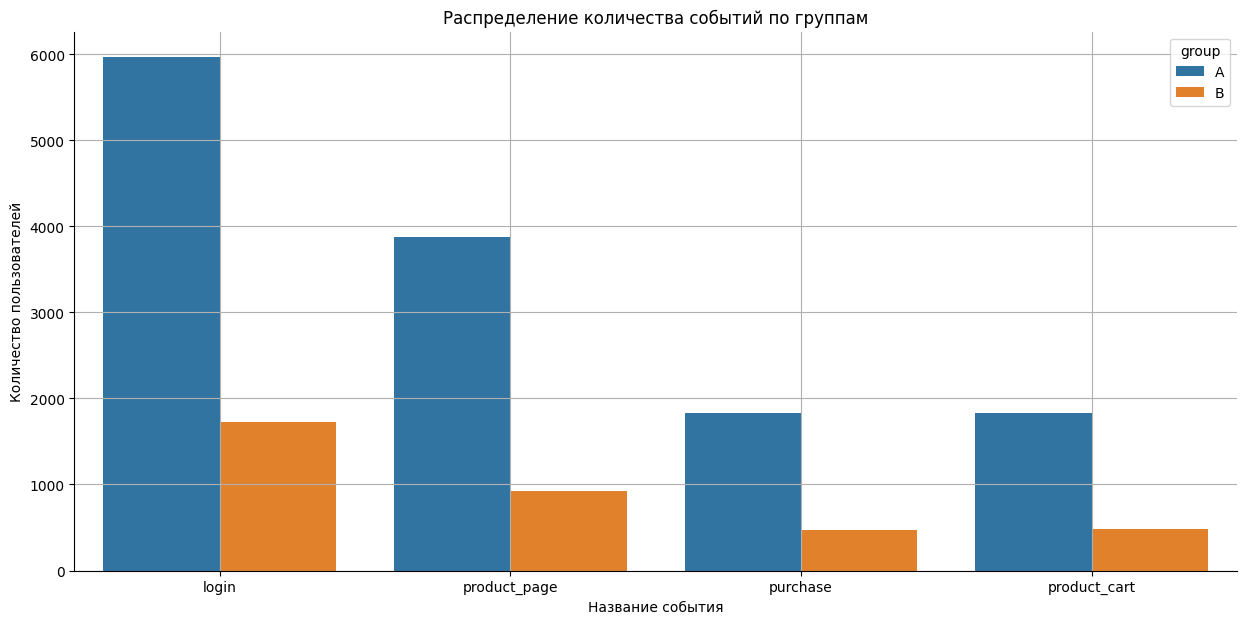

In [116]:
# Распределение количества событий в выборках по группам
plt.figure(figsize=(15, 7))
sns.barplot(data=events_count, x="event_name", y="user_id", hue="group", ci=None)
plt.title('Распределение количества событий по группам')
plt.ylabel('Количество пользователей')
plt.xlabel('Название события')
sns.despine()
plt.grid()
plt.show()

Диаграмма показывает:
- Неравномерность распределения событий по пользователям.
- Пользовательская актиность контрольной группы А значительно привосходит пользовательскую активность целевой группы В.

### Распределение событий по дням

In [117]:
# event_dt сконвертируем в формат даты
data_14['event_date'] = data_14.event_dt.dt.date

# Количество событий на пользователя за 14 дней
date_count = (
    data_14
    .groupby(['event_date','group'])
    .agg({'event_name': 'count'})
    .reset_index()
    .sort_values(by='event_date', ascending=True)
)

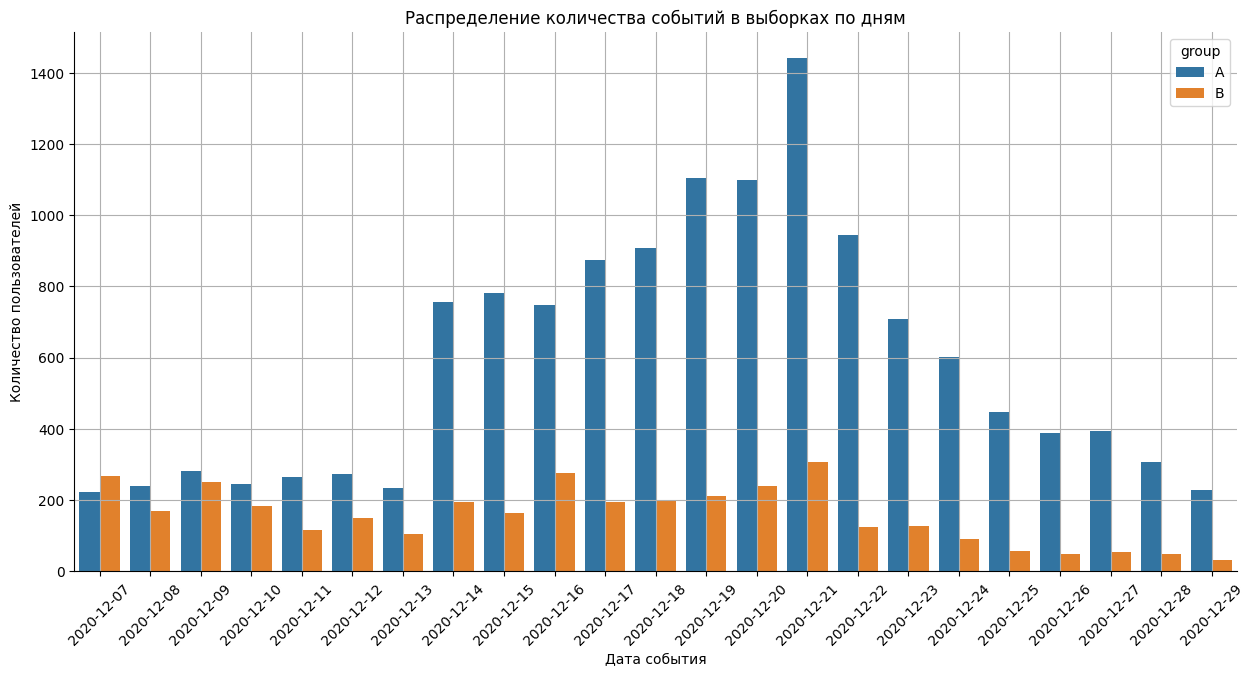

In [118]:
# Распределение количества событий в выборках по дням
plt.figure(figsize=(15, 7))
sns.barplot(data=date_count, x="event_date", y="event_name", hue="group", ci=None)
plt.title('Распределение количества событий в выборках по дням')
plt.ylabel('Количество пользователей')
plt.xlabel('Дата события')
sns.despine()
plt.grid()
plt.xticks(rotation=45)
plt.show()

Активность пользователей контрольной группы А превосходит активность целевой группы В. 

Пик роста трафика первые 15 дней теста, до 21 декабря, далее резкое снижение. Резкое снижение трафика обусловленно остановкой набора новых пользователей.

### Конверсия в воронке в выборках на разных этапах

Ранее мы выделили 4 этапа формирования воронки:
- авторизация `login`,
- просмотр карточек товаров `product_page`,
- просмотры корзины — `product_cart`,
- покупка — `purchase`.

Посмотрим как меняется конверсия в воронке в выборках на разных этапах.

In [119]:
# Отберем данные по событиям для построения вопронки
events_group_count = (
    data_14
    .pivot_table(index='event_name', values='user_id', columns='group', aggfunc='nunique')
    .sort_values(by='A', ascending=False)
    .reset_index()
)

# Изменим порядок строк для воронки
row_i = events_group_count.iloc[2].copy()
row_j = events_group_count.iloc[3].copy()
events_group_count.iloc[2] = row_j
events_group_count.iloc[3] = row_i                         

# Посчитаем конверсию для каждой группы
events_group_count['previous_A'] = round(events_group_count.A / events_group_count.A.shift(periods=1) * 100, 2)
events_group_count['previous_B'] = round(events_group_count.B / events_group_count.B.shift(periods=1) * 100, 2)
events_group_count = events_group_count.fillna(100)
events_group_count['percent_previous'] = events_group_count.previous_B - events_group_count.previous_A

# Посчитаем конверсию для каждой группы
events_group_count['initial_A'] = round(events_group_count.A / events_group_count.A.max() * 100, 2)
events_group_count['initial_B'] = round(events_group_count.B / events_group_count.B.max() * 100, 2)
events_group_count['percent_initial'] = events_group_count['initial_B'] - events_group_count['initial_A']

display(events_group_count)

group,event_name,A,B,previous_A,previous_B,percent_previous,initial_A,initial_B,percent_initial
0,login,1939,654,100.00,100.00,0.00,100.00,100.00,0.00
1,product_page,1265,367,65.24,56.12,-9.12,65.24,56.12,-9.12
2,product_cart,589,184,46.56,50.14,3.58,30.38,28.13,-2.25
3,purchase,613,191,104.07,103.80,-0.27,31.61,29.20,-2.41


In [120]:
# Построим воронки событий по группам
fig = make_subplots(rows=1, cols=2, subplot_titles=("Группа А","Группа В"))
fig.add_trace(
    go.Funnel(
        y = events_group_count.event_name,
        x = events_group_count.A,
        textposition = "inside",
        textinfo = "value+percent initial+percent previous",
        marker = {"color": "#ff442b"}
),
row=1, 
col=1)

fig.add_trace(
    go.Funnel(
        y = events_group_count.event_name,
        x = events_group_count.B,
    textposition = "inside",
    textinfo = "value+percent initial+percent previous",
    marker = {"color": "#606eff"}
),
row=1, 
col=2)

fig.update_layout(title='Воронки событий по группам', 
                  yaxis_title='События',
                  showlegend=False)
fig.show()

Анализ конверсии показал:

- Выйти на обозначенные 10% улучшения каждой из метрик не удалось. В контрольной группе А 30% пользователей перешли на страницу оплаты, в целевой группе - 27%.
- В группе В больше потеря пользователей, только 54% пользователей перешло к просмотру и выбору товара.
- Для обоих выборок процент просмотра Корзины меньше, чем страницы оплаты, что искажает формирование вопронки. Данный факт говорит о возможности оплаты товара без перехода в Корзину.
 

### Оценка особенности имеющихся данных

1. Фактическое кол-во участников теста существенно ниже ожидаемого.
2. Контрольная группа А и целевая группа В распределены неравномерно. 
3. 1602 пользователя теста попали одновременно в два теста, что очень сильно искажает результаты эксперимента.
4. Время проведения теста пересекается с маркетинговым мероприятием, а так же выпадает на конец года - период активных рождественских и новогодних распродаж.

Подводя итог: проведение А/В-тестирования в реальных условиях было бы пустой тратой ресурсов, так как достоверность была бы сомнительной, но так как проект учебный посмотрим на результаты тестирования.

## Анализ результатов А/В-тестирования

### Результаты A/B-тестирования

In [121]:
# Конверсия
display(events_group_count)

group,event_name,A,B,previous_A,previous_B,percent_previous,initial_A,initial_B,percent_initial
0,login,1939,654,100.00,100.00,0.00,100.00,100.00,0.00
1,product_page,1265,367,65.24,56.12,-9.12,65.24,56.12,-9.12
2,product_cart,589,184,46.56,50.14,3.58,30.38,28.13,-2.25
3,purchase,613,191,104.07,103.80,-0.27,31.61,29.20,-2.41


Результаты А/B теста для уникальных, выбранных пользователей EU при 14 днях наблюдения:

- product_page -9.12%
- product_cart 3.58%
- purchase -0.27%

Целевой показатель прироста 10% не был достигнут не на одном из шагов. 

### Проверка статистической разницы долей z-критерием

Подготовим функцию z_test, которая осуществляет тестирование на разность долей. 
Функция принимает на вход три параметра:

- df1: контрольная группа;
- df2: целевая группа;
- event: название события;
- alpha: критический уровень статистической значимости;
- n: количество экспериментов.

In [122]:
# Функция для оценки результатов Z теста
def z_test(df1, df2, event, alpha, n):      
    # критический уровень статистической значимости c поправкой Бонферрони
    bonferroni_alpha = alpha / n
 
    # число пользователей в группе 1 и группе 2:
    n_users = np.array([df1['user_id'].nunique(), 
                        df2['user_id'].nunique()])

    # число пользователей, совершивших событие в группе 1 и группе 2
    success = np.array([df1[df1['event_name'] == event]['user_id'].nunique(), 
                        df2[df2['event_name'] == event]['user_id'].nunique()])

    # пропорции успехов в группах:
    p1 = success[0]/n_users[0]
    p2 = success[1]/n_users[1]
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (success[0] + success[1]) / (n_users[0] + n_users[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference /  np.sqrt(p_combined * (1 - p_combined) * (1/n_users[0] + 1/n_users[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2   #тест двусторонний, удваиваем результат
    
    print('Событие:', event)
    print('p-значение: ', p_value)

    if p_value < bonferroni_alpha:
        status = 'Отвергаем нулевую гипотезу: между долями присутствует статистически значимая разница'
    else:
        status = 'Не получилось отвергнуть нулевую гипотезу, нет оснований полагать, что доли существенно различаются'
    print(status)
    return status

Сформулируем нулевую и альтернативную гипотезы:

        H0 - доли уникальных посетителей контрольной группы А и целевой группы В, одинаковы.
        H1 - доли уникальных посетителей контрольной группы А и целевой группы В различаются.

Уровень статистической значимости берем равным 0.5 с учетом поправки Бонферрони.

Поправка Бонферрони помогает уменьшить риск ошибки 1-го рода (ложного положительного результата), устанавливая более строгий уровень статистической значимости для каждого отдельного теста в наборе тестов. Она делает это путем деления заданного уровня значимости (обычно 0.05) на общее количество тестов. Таким образом, поправка Бонферрони уменьшает вероятность совершения ошибки 1-го рода, но может также увеличить вероятность ошибки 2-го рода (ложного отрицательного результата).

Использование поправки Бонферрони особенно полезно в исследованиях, где проводится множество статистических тестов, чтобы убедиться, что статистически значимые результаты действительно обусловлены различиями между группами или условиями, а не случайными колебаниями данных.

In [123]:
# z_test
events_group_count['z_test'] = '' 
page = events_group_count[events_group_count.event_name != 'login'].event_name.unique()
for event in page:
    events_group_count.loc[events_group_count.event_name == event, 'z_test'] = z_test(data_14[data_14.group == 'A'], 
            data_14[data_14.group == 'B'], event, 0.05, len(page))
print('')
display(events_group_count)

Событие: product_page
p-значение:  2.457788807452843e-05
Отвергаем нулевую гипотезу: между долями присутствует статистически значимая разница
Событие: product_cart
p-значение:  0.26899325584838074
Не получилось отвергнуть нулевую гипотезу, нет оснований полагать, что доли существенно различаются
Событие: purchase
p-значение:  0.24035836270660704
Не получилось отвергнуть нулевую гипотезу, нет оснований полагать, что доли существенно различаются



group,event_name,A,B,previous_A,previous_B,percent_previous,initial_A,initial_B,percent_initial,z_test
0,login,1939,654,100.00,100.00,0.00,100.00,100.00,0.00,
1,product_page,1265,367,65.24,56.12,-9.12,65.24,56.12,-9.12,Отвергаем нулевую гипотезу: между долями присутствует статистически значимая разница
2,product_cart,589,184,46.56,50.14,3.58,30.38,28.13,-2.25,"Не получилось отвергнуть нулевую гипотезу, нет оснований полагать, что доли существенно различаются"
3,purchase,613,191,104.07,103.80,-0.27,31.61,29.20,-2.41,"Не получилось отвергнуть нулевую гипотезу, нет оснований полагать, что доли существенно различаются"


C помощью z_test проверили, есть ли разница между долями конверсии контрольной группы А и целевой группы В:
- По событиям purchase и product_cart между долями уникальных посетителей нет статистически значимой разницы.
- По событиям product_page статистическая разница в долях уникальных посетителей существенная.

## Выводы

Результаты проведенного анализа тестирования указывают на отсутствие статистически значимой разницы в конверсии между группами А и В, за исключением этапа перехода от авторизации к просмотру карточки товара, где группа В продемонстрировала более низкую конверсию по сравнению с группой А.

Тем не менее, следует подчеркнуть, что проведение теста можно считать некорректным и его результаты - нерелевантными, ввиду определенных особенностей данных, предоставленных для анализа. К таким особенностям можно отнести:

1. Часть аудитории была одновременно задействована в двух различных тестах.
2. Распределение пользователей, участвующих одновременно в обоих тестах, между группами целевого теста было неравномерным.
3. Процент новых пользователей из Европы значительно ниже необходимого уровня.
4. Не для всех пользователей прошло 14 дней с момента регистрации к моменту тестирования.
5. Группы А и В в целевом тесте имеют различный размер.
6. Общее количество участников теста существенно меньше требуемого.
7. В период проведения теста действовала новогодняя/рождественская промоакция.

Эти факторы могли значительно повлиять на результаты тестирования и исказить их интерпретацию.